In [702]:
import pickle
import random
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.image as img
import cv2
import time
from tqdm import tqdm
import sys
import pyprind
import pandas as pd

from PIL import Image

In [703]:

def get_all_jpeg_files_paths(path):
    returnedFiles = []
    print(os.walk(path))
    for  r,d, files in os.walk(path):
        for file in files:
            if '.jpeg' in file:
                returnedFiles.append(os.path.join(r,file))
    return returnedFiles

In [704]:
train_normal_data_dir = r"c:\Faculta\advanced methods in data analysis\chest-xray-pneumonia\chest_xray\chest_xray\train\NORMAL"
train_normal_data_files = get_all_jpeg_files_paths(train_normal_data_dir) 


<generator object walk at 0x00000171804EB4F8>


In [705]:
train_pneumonia_data_dir=r"c:\Faculta\advanced methods in data analysis\chest-xray-pneumonia\chest_xray\chest_xray\train\PNEUMONIA"
train_pneumonia_data_files = get_all_jpeg_files_paths(train_pneumonia_data_dir)
test_normal_data_dir = r"c:\Faculta\advanced methods in data analysis\chest-xray-pneumonia\chest_xray\chest_xray\test\NORMAL"
test_normal_data_files = get_all_jpeg_files_paths(test_normal_data_dir)
test_pneumonia_data_dir = r"c:\Faculta\advanced methods in data analysis\chest-xray-pneumonia\chest_xray\chest_xray\test\PNEUMONIA"
test_pneumonia_data_files = get_all_jpeg_files_paths(test_pneumonia_data_dir)
valid_normal_data_dir = r"C:\Faculta\advanced methods in data analysis\chest-xray-pneumonia\chest_xray\val\NORMAL"
valid_normal_data_files = get_all_jpeg_files_paths(valid_normal_data_dir)
valid_pneumonia_data_dir = r"C:\Faculta\advanced methods in data analysis\chest-xray-pneumonia\chest_xray\val\PNEUMONIA"
valid_pneumonia_data_files = get_all_jpeg_files_paths(valid_pneumonia_data_dir)

<generator object walk at 0x00000171804EB318>
<generator object walk at 0x00000171804EB318>
<generator object walk at 0x00000171804EB318>
<generator object walk at 0x00000171804EB318>
<generator object walk at 0x00000171804EB318>


1341
3875
(1858, 2090)
(1858, 2090)


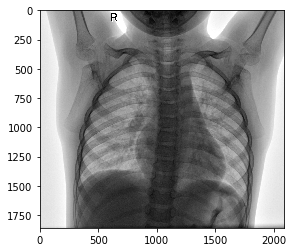

In [706]:
print(len(train_normal_data_files))
print(len(train_pneumonia_data_files))
image = img.imread(train_normal_data_files[0])
print(image.shape)
print(image.shape)

plt.imshow(image, cmap="binary")

In [707]:
def find_median_dimensions_from_files(paths_array):
    xAxis = []
    yAxis = []

    for path in pyprind.prog_percent(paths_array):
        image = img.imread(path)
        xAxis.append(image.shape[0])
        yAxis.append(image.shape[1])
    
    return np.median(xAxis), np.median(yAxis)

xAxisMedian, yAxisMedian = find_median_dimensions_from_files(train_normal_data_files)
print(xAxisMedian, yAxisMedian)


[100 %] Time elapsed: 00:00:35 | ETA: 00:00:00

1328.0 1640.0



Total time elapsed: 00:00:35


In [714]:
SIZE = (int(xAxisMedian), int(yAxisMedian))
imageResized = cv2.resize(image, (int(yAxisMedian), int(xAxisMedian)))
print(imageResized.shape)
print(SIZE[0]/SIZE[1])

(1328, 1640)
0.8097560975609757


In [712]:
def pooling(matrix, strides, method = 'max'): 
    m, n = matrix.shape[:2]
    strideY, strideX = strides
    mY=m//strideY
    nX=n//strideX
    matrix_pad = matrix[:mY*strideY, :nX*strideX, ...]
    print(matrix.shape[2:])
    
    new_shape=(mY,strideY,nX,strideX)+matrix_pad.shape[2:]
    print(n)
    if method == 'mean':
        result = np.nanmean(matrix_pad.reshape(new_shape),axis=(1,3))
    elif method=='max':
        result = np.nanmax(matrix_pad.reshape(new_shape), axis=(1,3))
    else:
        result = np.nanmin(matrix_pad.reshape(new_shape), axis=(1,3))

    return result

def flatten(matrix):
    if len(matrix.shape) == 2:
        return matrix.reshape(matrix.shape[0]*matrix.shape[1])
    else:
        return matrix.reshape(matrix.shape[0]*matrix.shape[1],matrix.shape[2])

()
1640
()
1640


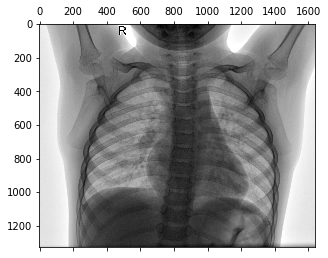

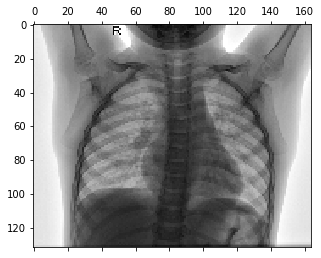

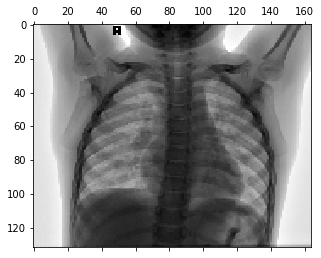

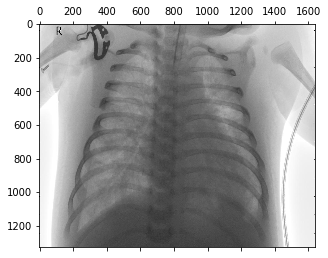

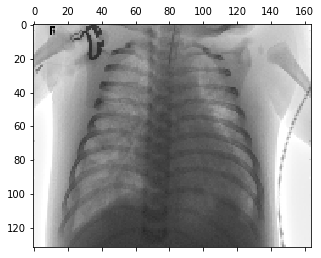

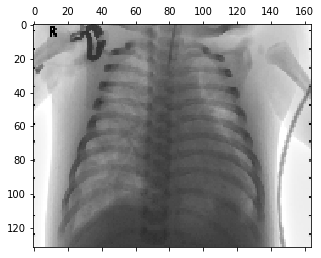

In [715]:
pneumonia_imageResized = cv2.resize(pneumonia_image,(SIZE[1], SIZE[0]))
SIZE = (SIZE[0]//10,SIZE[1]//10)
imageResized_2 = cv2.resize(imageResized, (SIZE[1],SIZE[0]))
imageResized_maxPooling = pooling(imageResized, (10,10))
pneumonia_image=img.imread(train_pneumonia_data_files[0])
pneumonia_imageResized_2 = cv2.resize(pneumonia_imageResized, (SIZE[1],SIZE[0]))
pneumonia_imageResized_maxPooling = pooling(pneumonia_imageResized, (10,10))
plt.matshow(imageResized, cmap="binary")
plt.matshow(imageResized_2, cmap="binary")
plt.matshow(imageResized_maxPooling, cmap="binary")
plt.matshow(pneumonia_imageResized, cmap='binary')
plt.matshow(pneumonia_imageResized_2, cmap='binary')
plt.matshow(pneumonia_imageResized_maxPooling, cmap='binary')
plt.show()


In [682]:
def load_data_from_files(paths_array):
    data = np.array([])
#     separating in more data-sets improves speed by over 40 time because np.dstack on high numbers is very slow
    data_sets = [np.array([])]
    current_set = 0
    for path in pyprind.prog_percent(paths_array):
        currentImage = img.imread(path)
        currentImageResized = cv2.resize(currentImage, (SIZE[1],SIZE[0]))
        if len(currentImageResized.shape) == 3:
            currentImageResized = currentImageResized[:,:,0]
        if data_sets[current_set].shape[0] != currentImageResized.shape[0]:
            data_sets[current_set] = currentImageResized
            data_sets[current_set] = data_sets[current_set].reshape(data_sets[current_set].shape[0],data_sets[current_set].shape[1],1)
        else:
            data_sets[current_set] = np.dstack((data_sets[current_set],currentImageResized))
        if data_sets[current_set].shape[2]>50:
            data_sets.append(np.array([]))
            current_set=current_set+1
    
    for data_set in pyprind.prog_percent(data_sets):
        if data.shape[0] != data_set.shape[0]:
            data = data_set
        else:
            data = np.dstack((data,data_set))
    
    return data

normal_train_data = load_data_from_files(train_normal_data_files)
print(normal_train_data.shape)
print(len(train_normal_data_files))
pneumonia_train_data = load_data_from_files(train_pneumonia_data_files)
print(pneumonia_train_data.shape)
print(len(train_pneumonia_data_files))


(264, 328, 1341)
1341
(264, 328, 3875)
3875


In [585]:

print(normal_train_data.shape)
print(pneumonia_train_data.shape)
print(SIZE)
all_train_data = np.dstack((normal_train_data,pneumonia_train_data))
print(all_train_data.shape)
all_train_data = flatten(all_train_data)
print(all_train_data.shape)


(264, 328, 1341)
(264, 328, 3875)
(264, 328)
(264, 328, 5216)
(86592, 5216)


In [684]:
def transform_into_list_with_results(data,dataType):
    normal_data_length = None
    if dataType == 'train':
        normal_data_length = len(train_normal_data_files)
    if dataType == 'test':
        normal_data_length = len(test_normal_data_files)
    if dataType == 'valid':
        normal_data_length = len(valid_normal_data_files)
    
    train_data_with_results = list() 
    for  i in pyprind.prog_percent(range(len(data[0]))): 
        if i < normal_data_length:
            train_data_with_results.append((data[:,i], 0)) 
            train_data_with_results.append((data[:,i], 1)) 
train_data_with_results =  transform_into_list_with_results(all_train_data,'train')   


In [588]:

print(train_data_with_results[0][0].shape)
test_normal_data = load_data_from_files(test_normal_data_files)
test_pneumonia_data = load_data_from_files(test_pneumonia_data_files)
all_test_data = np.dstack((test_normal_data,test_pneumonia_data))
all_test_data = flatten(all_test_data)
test_data = transform_into_list_with_results(all_test_data,'test')  
print(all_test_data.shape)




(86592,)


[100 %] Time elapsed: 00:00:05 | ETA: 00:00:00
Total time elapsed: 00:00:05
[100 %] Time elapsed: 00:00:00 | ETA: 00:00:00
Total time elapsed: 00:00:00
[100 %] Time elapsed: 00:00:04 | ETA: 00:00:00
Total time elapsed: 00:00:04
[100 %] Time elapsed: 00:00:00 | ETA: 00:00:00
Total time elapsed: 00:00:00
[100 %] Time elapsed: 00:00:00 | ETA: 00:00:00

(86592, 624)



Total time elapsed: 00:00:00


In [687]:
valid_normal_data = load_data_from_files(valid_normal_data_files)
valid_pneumonia_data = load_data_from_files(valid_pneumonia_data_files)
all_valid_data = np.dstack((valid_normal_data,valid_pneumonia_data))
all_valid_data = flatten(all_valid_data)
validation_data = transform_into_list_with_results(all_valid_data,'valid')  
print(all_valid_data.shape)
print(len(validation_data))

[100 %] Time elapsed: 00:00:00 | ETA: 00:00:00
Total time elapsed: 00:00:00
[100 %] Time elapsed: 00:00:00 | ETA: 00:00:00
Total time elapsed: 00:00:00
[100 %] Time elapsed: 00:00:00 | ETA: 00:00:00
Total time elapsed: 00:00:00
[100 %] Time elapsed: 00:00:00 | ETA: 00:00:00
Total time elapsed: 00:00:00
[100 %] Time elapsed: 00:00:00 | ETA: 00:00:00

(86592, 16)
<class 'list'>
16



Total time elapsed: 00:00:00


In [700]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x)*(1-sigmoid(x))

def Conv2D(x, W1, W2, W3, B1, B2, B3):
    """Return the output of the network if ``x`` is input image and
    W1, W2, B1 and B2 are the learnable weights. """
    Z1 = np.dot(W1, x.reshape(len(x),1)) + B1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2, A1) + B2
    A2 = sigmoid(Z2) 
    Z3 = np.dot(W3, A2) + B3
    A3 = sigmoid(Z3) 
    return A3[0][0]

In [701]:
def vectorize_mini_batch(mini_batch):

    X = np.array([])
    for k in range(0,len(mini_batch)):
        x=mini_batch[k][0]
        x=x.reshape(len(x),1) 
        if X.shape[0] != x.shape[0]:
            X=x
        else:
            X=np.concatenate((X,x),axis=1) 
    Y = np.array([])
    for k in range(0,len(mini_batch)):
        Y=np.append(Y,[mini_batch[k][1]],axis=0)
    return X,Y


In [722]:
def gradientDescent(training_data, epochs, mini_batch_size, eta, test_data, beta=None, weights=None):
#     if beta is sent this function works as a gradient descent with momentum otherwise it works as a Stochastic gradient Descent

    
    n = len(training_data)
    n_test = len(test_data)
    flattenedImageSize=len(training_data[0][0])
    W1 = np.random.randn(1000,flattenedImageSize)
    W2 = np.random.randn(50, 1000)
    W3 = np.random.randn(1, 50)
    B1 = np.random.randn(1000, 1)
    B2 = np.random.randn(50, 1)
    B3 = np.random.randn(1, 1)
    
#     initialization for momentum
    vdW1=0
    vdW2=0
    vdW3=0
    vdB1=0
    vdB2=0
    vdB3=0
    
    if weights is not None:
        W1 = weights['W1']
        W2 = weights['W2']
        W3 = weights['W3']
        B1 = weights['B1']
        B2 = weights['B2']
        B3 = weights['B3']
    
    
    for j in pyprind.prog_percent(range(epochs)):
        random.shuffle(training_data)
        for k in pyprind.prog_percent(range(0, mini_batch_size)):
            mini_batch = training_data[k:k+mini_batch_size]
            X, Y = vectorize_mini_batch(mini_batch)
            Z1 = np.dot(W1, X) + B1 
            A1 = sigmoid(Z1) 
            Z2 = np.dot(W2, A1) + B2
            A2 = sigmoid(Z2)  #50,10
            Z3 = np.dot(W3, A2) + B3   #1,10
            A3 = sigmoid(Z3)

            # backpropagate(vectorized)
            dZ3 = 1/mini_batch_size*(A3-Y)*sigmoid_prime(Z3)    #1,10
            dW3 = np.dot(dZ3, A2.T)    #
            dB3 = 1/mini_batch_size*np.sum(dZ3, axis=1, keepdims=True)          
            dZ2 = 1/mini_batch_size*np.dot(W3.T, dZ3)*sigmoid_prime(Z2)
            dW2 = np.dot(dZ2, A1.T)
            dB2 = 1/mini_batch_size*np.sum(dZ2, axis=1, keepdims=True)          
            dZ1 = 1/mini_batch_size*np.dot(W2.T, dZ2)*sigmoid_prime(Z1)
            dW1 = np.dot(dZ1, X.T)
            dB1 = 1/mini_batch_size*np.sum(dZ1, axis=1, keepdims=True)
            
            # update parameters by making a gradient step
            
            #momentum gradient
            if beta is not None:
                vdW1=beta*vdW1+dW1*(1-beta)
                vdW2=beta*vdW2+dW2*(1-beta)
                vdW3=beta*vdW3+dW3*(1-beta)
                vdB1=beta*vdB1+dB1*(1-beta)
                vdB2=beta*vdB2+dB2*(1-beta)
                vdB3=beta*vdB3+dB3*(1-beta)
                W3 = W3-eta*vdW3
                W2 = W2-eta*vdW2
                W1 = W1-eta*vdW1
                B3 = B3-eta*vdB3
                B2 = B2-eta*vdB2
                B1 = B1-eta*vdB1
            else:
                W3 = W3-eta*dW3
                W2 = W2-eta*dW2
                W1 = W1-eta*dW1
                B3 = B3-eta*dB3
                B2 = B2-eta*dB2
                B1 = B1-eta*dB1
            
#  accuracy
        accuracy=[]
        averageError=[]
        for (x,y) in pyprind.prog_percent((test_data)):
            predictedValue = Conv2D(x, W1, W2, W3,B1, B2, B3)
            accuracy.append(int(round(predictedValue) == y))
            averageError.append(abs(y-predictedValue))
        accuracy = np.mean(accuracy)
        averageError = np.mean(averageError)
        print("Epoch {} : {} % -->averageError {}".format(j, accuracy, averageError ));
    return W1, B1, W2, B2, W3, B3




In [ ]:
W1, B1, W2, B2, W3, B3 = gradientDescent(train_data_with_results, 5, 64, 0.3, test_data, weights=storedWeights)

C:\Users\simion.cira\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
[100 %] Time elapsed: 00:02:19 | ETA: 00:00:00
Total time elapsed: 00:02:19
[100 %] Time elapsed: 00:00:22 | ETA: 00:00:00
Total time elapsed: 00:00:22
[ 20 %] Time elapsed: 00:02:41 | ETA: 00:10:47

Epoch 0 : 0.7035256410256411 % -->averageError 0.30531968504022383


[100 %] Time elapsed: 00:02:09 | ETA: 00:00:00
Total time elapsed: 00:02:09
[ 10 %] Time elapsed: 00:00:02 | ETA: 00:00:17

In [699]:
def predict(images, W1, W2, W3, B1, B2, B3):
    predictions = []
    for im in images:
        a = Conv2D(im[0], W1, W2, W3, B1, B2, B3)
        predictions.append(int(round(a)))
    return predictions


In [698]:
storedWeights={"W1":W1,"W2":W2,"W3":W3,"B1":B1,"B2":B2,"B3":B3}

C:\Users\simion.cira\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1]
(array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), 0)


In [697]:
with open('storedWeightsW1W2W3B1B2B3.pkl', 'wb') as f:
    pickle.dump([W1, W2,W3,B1,B2,B3], f)


In [696]:
with open('storedWeightsDict.pkl', 'wb') as f:
    pickle.dump(storedWeights, f)

In [695]:
sampling = random.choices(train_data_with_results,k=100)
predictions = predict(sampling, W1, W2, W3, B1, B2, B3)

def check_accuracy(expectedValues, actualValues):
    loss_values = []
    counter = 0
    for value in actualValues:
        loss_values.append(abs(value[1]-expectedValues[counter]))
        counter+=1
    loss=np.mean(loss_values)
    return 1-loss

print('accuraccy on training set is: ',check_accuracy(predictions,sampling))
test_sampling = random.choices(test_data, k=100)
print('accuraccy on testing set is: ',check_accuracy(predict(test_sampling, W1, W2, W3, B1, B2, B3),test_sampling))
print('accuraccy on validation set is: ',check_accuracy(predict(validation_data, W1, W2, W3, B1, B2, B3),validation_data))

C:\Users\simion.cira\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


accuraccy on training set is:  0.73
accuraccy on testing set is:  0.69
accuraccy on validation set is:  0.9375
